<center><h1>Прогнозирования оттока клиентов оператора</h1></center>

## План работы

1) Изучение технического задания проекта.

2) Загрузка, группировка, предобработка данных.

4) Добавление целевой переменной. Добавление новых признаков. Выявление зависимостей.

5) Подготовка данных к созданию и обучению моделей.

6) Выбор моделей машинного обучения. Тестирование.

7) Оценка важности признаков.

8) Итоговый вывод.

## Установка необходимых пакетов. Импорт библиотек.

In [1]:
#!pip install phik
#!pip install --upgrade matplotlib
#!pip install --upgrade pandas
#!pip install --upgrade scikit-learn
#!pip install os
#!pip install lightgbm
#!pip install yellowbrick
#!pip install shap
#!pip install catboost
#!pip install imblearn

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from yellowbrick.classifier import ROCAUC, ConfusionMatrix

import phik
from phik.report import plot_correlation_matrix

import shap
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

import warnings

from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.dummy import DummyClassifier

from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, accuracy_score

## Добавление констант

Дата формирования отчёта в формате Год-Месяц-День (YYYY-mm-dd)

In [3]:
REPORT_DATE = '2020-02-01' 
STATE = 280823

## Знакомство с данными. Предобработка.

In [4]:
def read_data (path, 
               local_path, 
               name=[], 
               index_col=[0], 
               parse_dates=[1], 
               date_format='%Y-%m-%d'):
    if (os.path.exists(path)):
        data = pd.read_csv(path, 
                           index_col=index_col, 
                           parse_dates=parse_dates,
                           date_format=date_format)
    elif os.path.exists(local_path):
        data = pd.read_csv(local_path, 
                           index_col=index_col, 
                           parse_dates=parse_dates,
                           date_format=date_format)
    else:
        print(f'Не удалось загрузить данные {name}! Проверьте путь.')
    return data

contract_path = '/datasets/contract_new.csv'
personal_path = '/datasets/personal_new.csv'
internet_path = '/datasets/internet_new.csv'
phone_path = '/datasets/phone_new.csv'

contract_path_local = '/work/datasets/contract_new.csv'
personal_path_local = '/work/datasets/personal_new.csv'
internet_path_local = '/work/datasets/internet_new.csv'
phone_path_local = '/work/datasets/phone_new.csv'

contract = read_data (contract_path, contract_path_local, 'contract')
personal = read_data (personal_path, personal_path_local, 'personal')
internet = read_data (internet_path, internet_path_local, 'internet')
phone = read_data (phone_path, phone_path_local, 'phone')

Проверим наличие дублирующих индексов (номера договоров)

In [5]:
contract.index.duplicated().sum(), \
personal.index.duplicated().sum(), \
internet.index.duplicated().sum(), \
phone.index.duplicated().sum()

(0, 0, 0, 0)

Посмотрим структуру и объем данных 

In [6]:
contract.info()
print()
personal.info()
print()
internet.info()
print()
phone.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 698.2+ KB

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   

In [7]:
contract.sort_values(by='BeginDate').head(10)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
8580-QVLOC,2013-10-01,No,Two year,No,Credit card (automatic),92.45,7026.2
2889-FPWRM,2013-10-01,No,One year,Yes,Bank transfer (automatic),117.80,9221.38
0917-EZOLA,2013-10-01,No,Two year,Yes,Bank transfer (automatic),104.15,7915.4
2834-JRTUA,2013-11-01,No,Two year,Yes,Electronic check,108.05,8184.79
7317-GGVPB,2013-11-01,No,Two year,Yes,Credit card (automatic),108.60,8145.0
1555-DJEQW,2013-12-01,2014-11-01,Two year,Yes,Bank transfer (automatic),114.20,1281.32
2530-ENDWQ,2013-12-01,No,Two year,Yes,Bank transfer (automatic),93.70,6933.8
3512-IZIKN,2013-12-01,2017-10-01,Two year,No,Credit card (automatic),65.30,3003.8
6034-ZRYCV,2014-01-01,2016-09-01,Two year,Yes,Electronic check,54.20,1890.5


In [8]:
personal.head(10)

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No
9305-CDSKC,Female,0,No,No
1452-KIOVK,Male,0,No,Yes
6713-OKOMC,Female,0,No,No
7892-POOKP,Female,0,Yes,No


In [9]:
internet.head(10)

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No
9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
6713-OKOMC,DSL,Yes,No,No,No,No,No
7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes


In [10]:
phone.head(10)

,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes
7892-POOKP,Yes
6388-TABGU,No
9763-GRSKD,No
7469-LKBCI,No


### Объединение таблиц в одну.

In [11]:
contract.sort_values(by='BeginDate').tail(20)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
9629-NHXFW,2020-01-01,No,Month-to-month,Yes,Mailed check,19.40,19.4
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
0247-SLUJI,2020-01-01,No,Month-to-month,No,Mailed check,19.70,19.7
8992-CEUEN,2020-01-01,No,Month-to-month,No,Electronic check,18.85,20.36
3645-DEYGF,2020-01-01,No,Month-to-month,No,Mailed check,20.75,22.0
8950-MTZNV,2020-01-01,No,Month-to-month,Yes,Mailed check,44.95,46.3
8566-YPRGL,2020-01-01,No,Month-to-month,Yes,Mailed check,19.50,19.5
9617-INGJY,2020-01-01,No,Month-to-month,Yes,Mailed check,70.60,70.6
4195-NZGTA,2020-01-01,No,Month-to-month,No,Electronic check,25.25,25.25


In [12]:
data = (contract.join(personal, how='left')
                .join(internet, how='left')
                .join(phone, how='left'))

In [13]:
data.head(10).T

customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU,9305-CDSKC,1452-KIOVK,6713-OKOMC,7892-POOKP,6388-TABGU
BeginDate,2020-01-01 00:00:00,2017-04-01 00:00:00,2019-10-01 00:00:00,2016-05-01 00:00:00,2019-09-01 00:00:00,2019-03-01 00:00:00,2018-04-01 00:00:00,2019-04-01 00:00:00,2017-07-01 00:00:00,2014-12-01 00:00:00
EndDate,No,No,No,No,No,No,No,No,No,2017-05-01
Type,Month-to-month,One year,Month-to-month,One year,Month-to-month,Month-to-month,Month-to-month,Month-to-month,Month-to-month,One year
PaperlessBilling,Yes,No,Yes,No,Yes,Yes,Yes,No,Yes,No
PaymentMethod,Electronic check,Mailed check,Mailed check,Bank transfer (automatic),Electronic check,Electronic check,Credit card (automatic),Mailed check,Electronic check,Bank transfer (automatic)
MonthlyCharges,29.85,56.95,53.85,42.3,70.7,99.65,89.1,29.75,104.8,56.15
TotalCharges,31.04,2071.84,226.17,1960.6,353.5,1150.96,2058.21,300.48,3573.68,1628.35
gender,Female,Male,Male,Male,Female,Female,Male,Female,Female,Male
SeniorCitizen,0,0,0,0,0,0,0,0,0,0
Partner,Yes,No,No,No,No,No,No,No,Yes,No


### Заполнение пропусков

Пропуски в при объединении с таблицей phone свзаны вероятнее всего с тем, что услуга телефонии не оказывается. <br>
- Добавим новый столбец для услуги "телефония". Услуга имеется, данные о пользователе представлены в таблице Phone.
- Заполним пропуски значением No в столбце мультиканальность.

In [14]:
data['Phone'] = data.apply(lambda x: True if x.name in list(phone.index) else False, axis=1)
data['MultipleLines'].fillna('NotUsed', inplace=True)


In [15]:
data.isna().sum()

BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines          0
Phone                  0
dtype: int64

Пропуски в столбцах с интернет сервисом и прочими услугами заполним значением 'No', означающее, что клиент не пользуется данными услугами.

In [16]:
data.fillna('NotUsed', inplace=True)

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   object        
 7   gender            7043 non-null   object        
 8   SeniorCitizen     7043 non-null   int64         
 9   Partner           7043 non-null   object        
 10  Dependents        7043 non-null   object        
 11  InternetService   7043 non-null   object        
 12  OnlineSecurity    7043 non-null   object        
 13  OnlineBackup      7043 non-null   object        
 14  DeviceProtecti

### Оптимизация таблицы за счёт выбора подходящих типов данных.

Рассмотрим какие значения могут принимать столбцы с категориальными признаками

In [18]:
data['Type'].unique(), \
data['PaymentMethod'].unique(), \
data['gender'].unique(), \
data['InternetService'].unique()

(array(['Month-to-month', 'One year', 'Two year'], dtype=object),
 array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
        'Credit card (automatic)'], dtype=object),
 array(['Female', 'Male'], dtype=object),
 array(['DSL', 'Fiber optic', 'NotUsed'], dtype=object))

Приведём столбцы к подходящим для тих типам данных.

In [19]:
data['Type'] = data['Type'].astype('category')
data['PaymentMethod'] = data['PaymentMethod'].astype('category')
data['gender'] = data['gender'].astype('category')
data['InternetService'] = data['InternetService'].astype('category')

data['MonthlyCharges'] = data['MonthlyCharges'].astype('float16')
data['TotalCharges'] = data['TotalCharges'].replace(' ', 0).astype('float16')

In [20]:
data['MultipleLines'] = data['MultipleLines'].astype('category')
data['PaperlessBilling'] = data['PaperlessBilling'].astype('category')
data['SeniorCitizen'] = data['SeniorCitizen'].astype('category')
data['Partner'] = data['Partner'].astype('category')
data['Dependents'] = data['Dependents'].astype('category')
data['OnlineSecurity'] = data['OnlineSecurity'].astype('category')
data['OnlineBackup'] = data['OnlineBackup'].astype('category')
data['DeviceProtection'] = data['DeviceProtection'].astype('category')
data['TechSupport'] = data['TechSupport'].astype('category')
data['StreamingTV'] = data['StreamingTV'].astype('category')
data['StreamingMovies'] = data['StreamingMovies'].astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   category      
 3   PaperlessBilling  7043 non-null   category      
 4   PaymentMethod     7043 non-null   category      
 5   MonthlyCharges    7043 non-null   float16       
 6   TotalCharges      7043 non-null   float16       
 7   gender            7043 non-null   category      
 8   SeniorCitizen     7043 non-null   category      
 9   Partner           7043 non-null   category      
 10  Dependents        7043 non-null   category      
 11  InternetService   7043 non-null   category      
 12  OnlineSecurity    7043 non-null   category      
 13  OnlineBackup      7043 non-null   category      
 14  DeviceProtecti

### Создание новых признаков и целевой переменной.

Создадим 5 новых столбцов:<br>
1) Столбец Closed (1, 0). Расторжен контракт или нет. В дальнейшем это будет целевой переменной.<br>
2) ContractDuration - rоличество дней с момента заключения договора.<br>
3) Столбец OtherCharges - прочие расходы в дополнении к договору.<br>
4) Из даты открытия контракта создадим столбцы с месяцем и годом заключения контракта.

In [21]:
report_timestamp = pd.to_datetime(REPORT_DATE, format='%Y-%m-%d')

data['ContractDuration'] = \
    (pd.to_datetime(data['EndDate']
       .replace('No', report_timestamp)) - \
     pd.to_datetime(data['BeginDate'])).apply(lambda x: x.days) #round(x.days/((365*3+366)/48)))

data['Year'] = data['BeginDate'].apply(lambda x: x.year)
data['Month'] = data['BeginDate'].apply(lambda x: x.month)


In [22]:
data['Closed'] = data['EndDate'].apply(lambda x: 0 if x == 'No' else 1)

In [23]:
data['OtherCharges'] = data['TotalCharges'] - \
                       (data['ContractDuration']*round(data['MonthlyCharges']/((365*3+366)/48)))
data['OtherCharges'].describe()

count    7043.000000
mean        8.316220
std       353.497583
min     -1068.000000
25%      -171.625000
50%       -18.593750
75%       139.500000
max      1771.000000
Name: OtherCharges, dtype: float64

Как видим некоторые пользователи платят больше чем это придусмотрено контрактом, а некоторые меньше из-за наличия персональной скидки. <br>Создадим новый признак discount принимающий значения True, False.

In [24]:
data['Discount'] = \
    data['OtherCharges'].apply(lambda x: True if x<0 else False)
data['Discount'].value_counts()

Discount
True     3954
False    3089
Name: count, dtype: int64

Создадим дополнительный столбец тип контракта (телефон, интернет, телефон+интернет)


In [25]:
data['Services'] = 'All' # клиент пользуется всеми сервисами
data.loc[data['Phone'] == False, 'Services'] = 'Internet'
data.loc[data['InternetService'] == 'NotUsed', 'Services'] = 'Phone' # клиент пользуется только услугами телефонной связи
data['Services'] = data['Services'].astype('category')

Создадим дополнительный столбец с количеством доп услуг.

In [26]:
data['Extras'] = \
    data[['OnlineSecurity',
          'OnlineBackup',
          'DeviceProtection',
          'TechSupport', 
          'StreamingTV', 
          'StreamingMovies',
          'MultipleLines']].map(lambda x: 
                                    1 if x.lower().find('yes') >=0
                                    else 0)\
                           .sum(axis=1)

## Анализ данных

### Построение матрицы корреляции для поиска зависимостей.

In [27]:
warnings.filterwarnings('ignore')
data_corr = (data.drop('EndDate', axis=1)
                 .phik_matrix(interval_cols=['MonthlyCharges',
                                             'TotalCharges',
                                             'OtherCharges',
                                             'ContractDuration']))
warnings.filterwarnings('default')

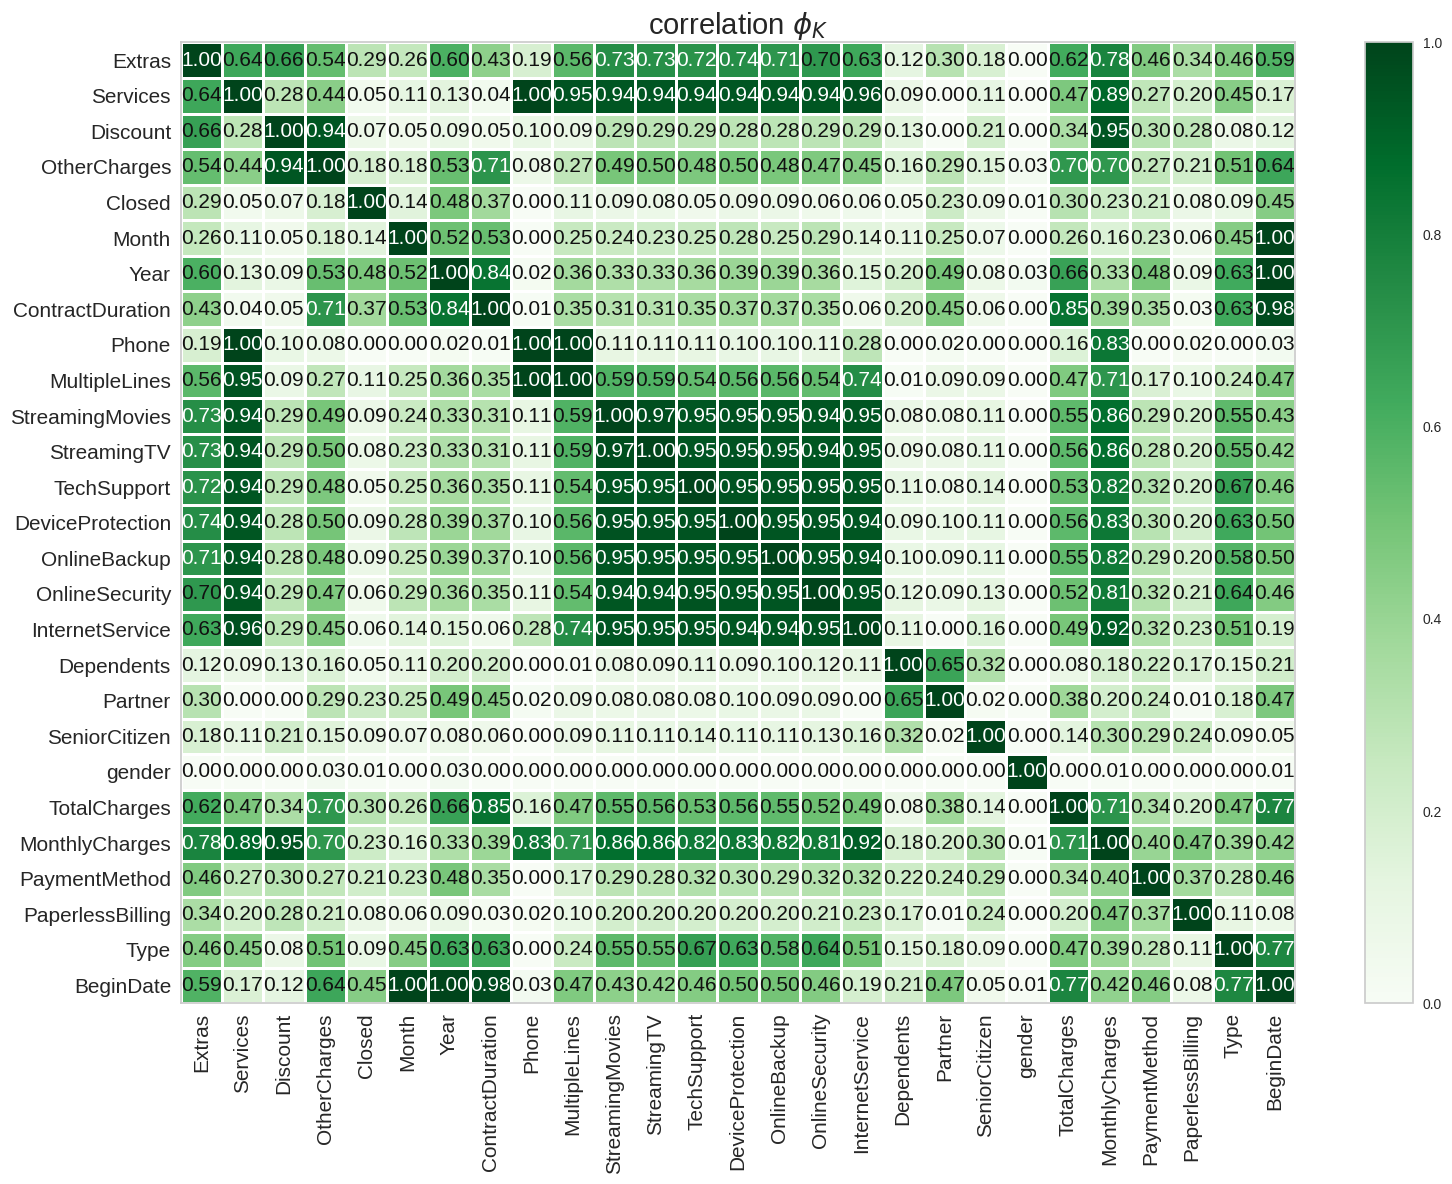

In [28]:
plot_correlation_matrix(data_corr.values, 
                        x_labels=data_corr.columns, 
                        y_labels=data_corr.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(16, 12))

В матрице корреляции нас интересуют больше всего столбцец Closed как ключевая переменая.<br>
Предварительный вывод: <br>
1) Уход клиентов слабо зависит от наличия скидки, пола клиента, вида основных услуг, типа интернет подключения.<br>
2) Обнаружена средняя зависимость расторжение контракта сильно зависит от даты заключения контракта и соответственно от длительности действия контракта (в меньшей степени), суммы расходов. Можно лишь предположить, что в какой-то момент были максимально выгодные условия для клиентов и поэтому они до сих пользуются услугами компании и наоборот.<br>
3) Для более наглядной интерпретации результатов необходимо построить отдельные диаграммы.  

### Построение диаграмм и графиков зависимостей.

Создадим функцию, которая будет строить диаграмму зависимость статуса статуса контракта от категориального признака 

In [29]:
def bar_cat_sigh (data, cat_sigh, title, xlabel='', kind='bar', figsize=(10,6)):
    tab = data.pivot_table(index=cat_sigh, 
                           columns='Closed',
                           values='gender',
                           aggfunc='count').fillna(0)

    tab_per = tab.div(tab.sum(axis=1),axis=0)    
    ax = tab.plot(kind=kind, 
                  ylabel='Количество контрактов',
                  xlabel=xlabel,
                  figsize=figsize)
    for container in ax.containers:
        ax.bar_label(container)
    plt.title(title)
    plt.show()
    

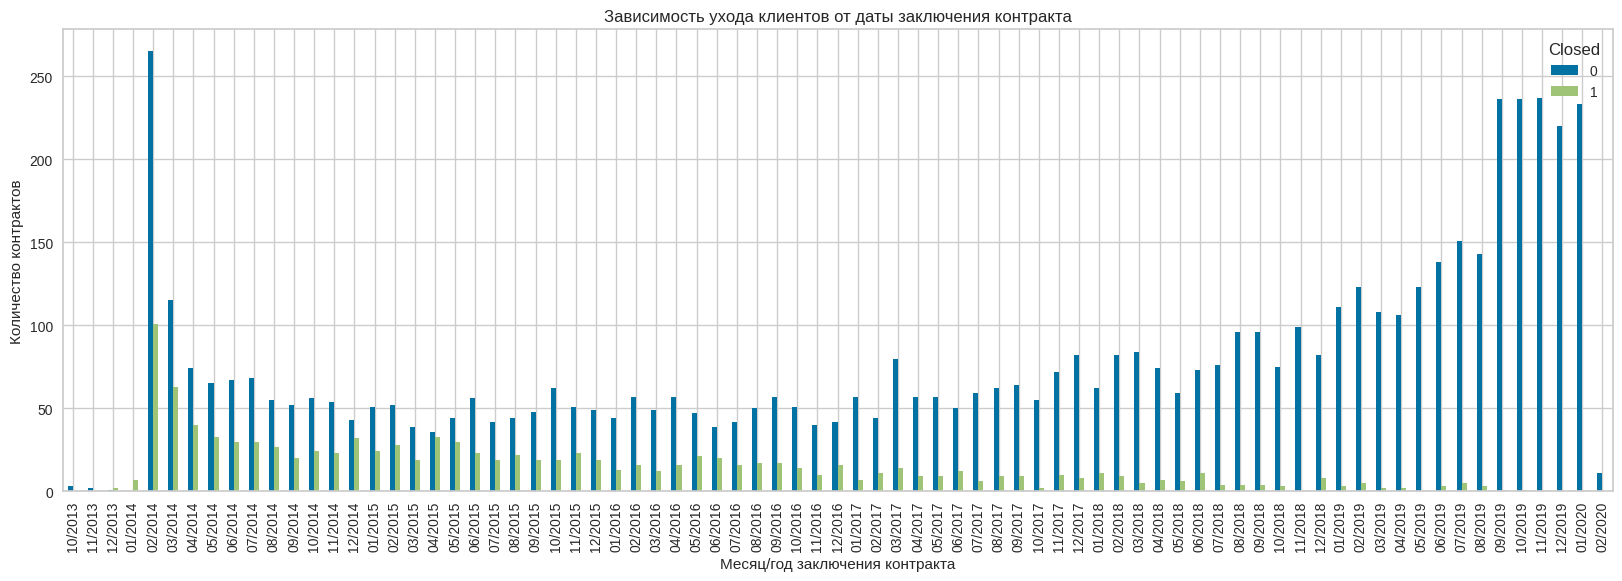

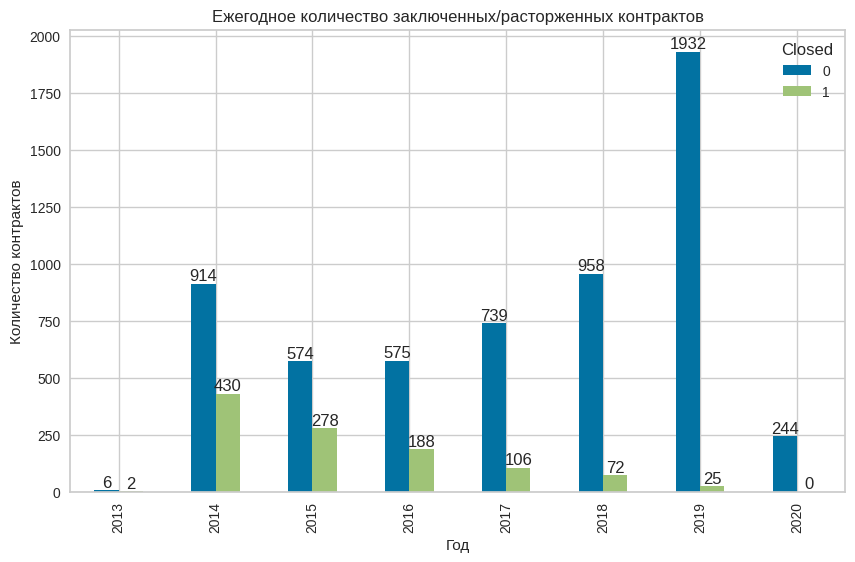

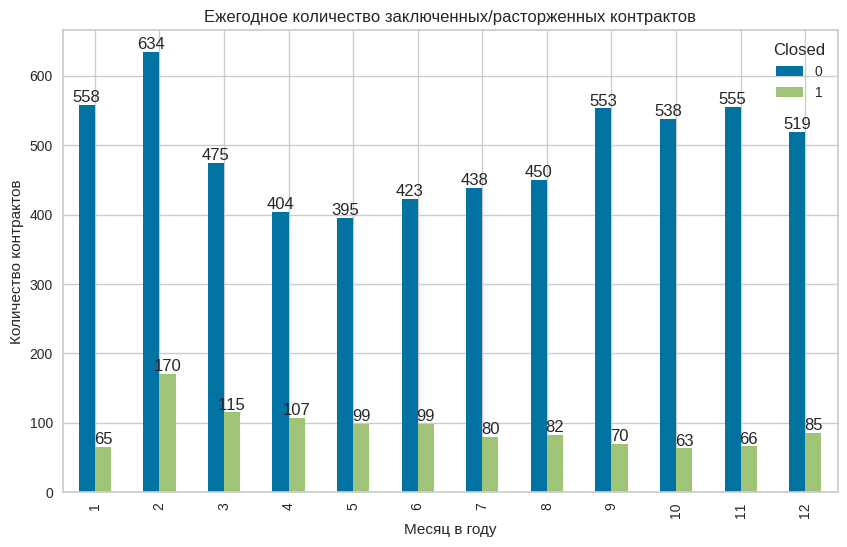

In [30]:
table = (data.pivot_table(index='BeginDate', 
                          columns='Closed', 
                          values='gender', 
                          aggfunc='count')
             .fillna(0))
table.index = table.index.strftime('%m/%Y')
table.plot(kind='bar', 
           figsize=(20,6),
           title='Зависимость ухода клиентов от даты заключения контракта',
           ylabel='Количество контрактов',
           xlabel='Месяц/год заключения контракта');

bar_cat_sigh(data, 
             'Year', 
             'Ежегодное количество заключенных/расторженных контрактов',
             'Год')

bar_cat_sigh(data, 
             'Month', 
             'Ежегодное количество заключенных/расторженных контрактов',
             'Месяц в году')

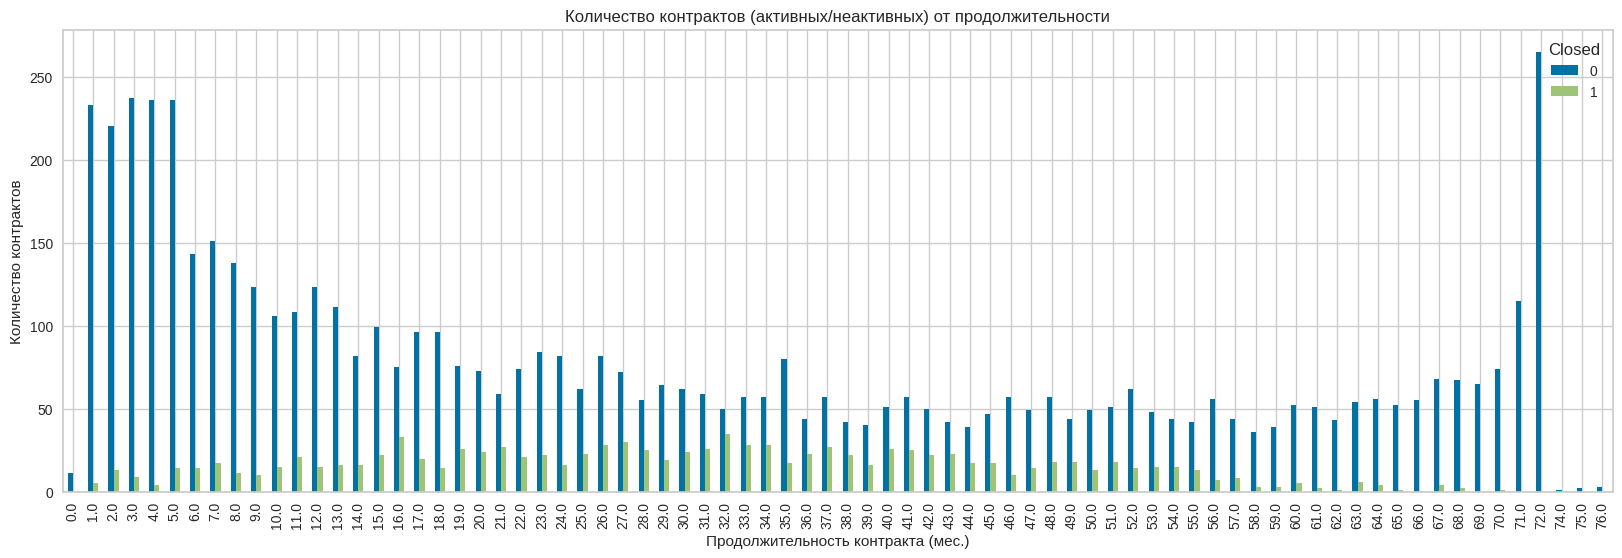

In [31]:
data[['Closed','gender']]\
    .join(round(data['ContractDuration']/((365*3+366)/48)))\
    .pivot_table(index='ContractDuration', 
                 columns ='Closed',
                 values='gender', 
                 aggfunc='count') \
     .sort_index()\
     .plot(kind='bar',
           figsize=(20,6),
           xlabel='Продолжительность контракта (мес.)',
           ylabel='Количество контрактов',
           title='Количество контрактов (активных/неактивных) от продолжительности');

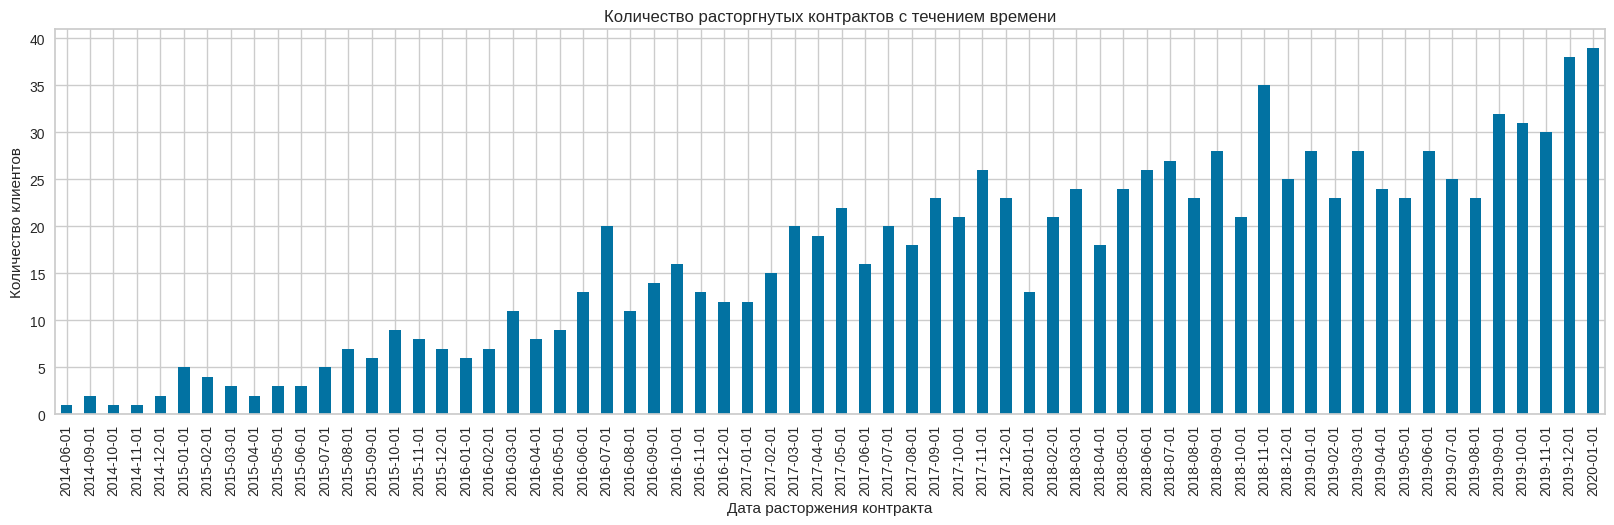

In [32]:
(data[data['Closed'] == 1]
     .pivot_table(index='EndDate', 
                  columns ='Closed',
                  values='gender', 
                  aggfunc='count') 
     .sort_index() 
     .plot(kind='bar',
           figsize=(20,5),
           legend=False,
           xlabel='Дата расторжения контракта',
           ylabel='Количество клиентов',
           title='Количество расторгнутых контрактов с течением времени'));

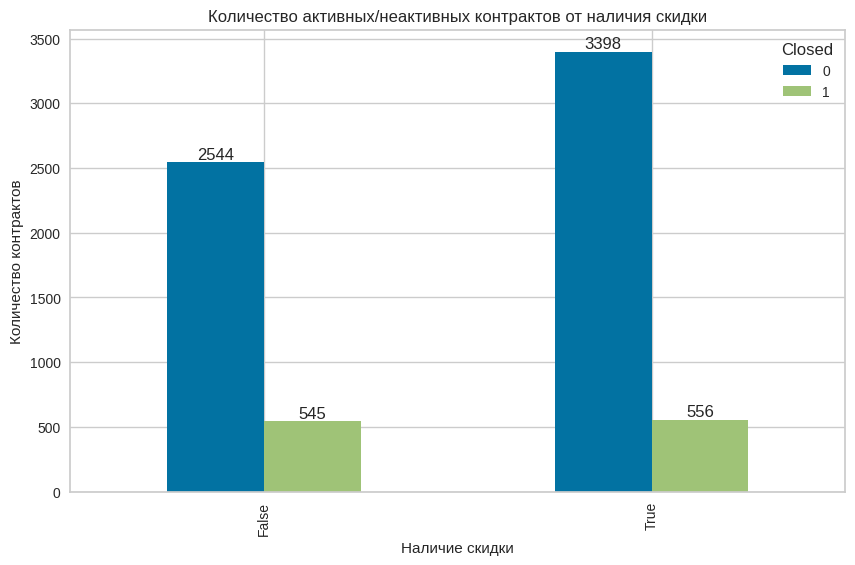

In [33]:
bar_cat_sigh(data, 
             'Discount', 
             'Количество активных/неактивных контрактов от наличия скидки',
             'Наличие скидки')

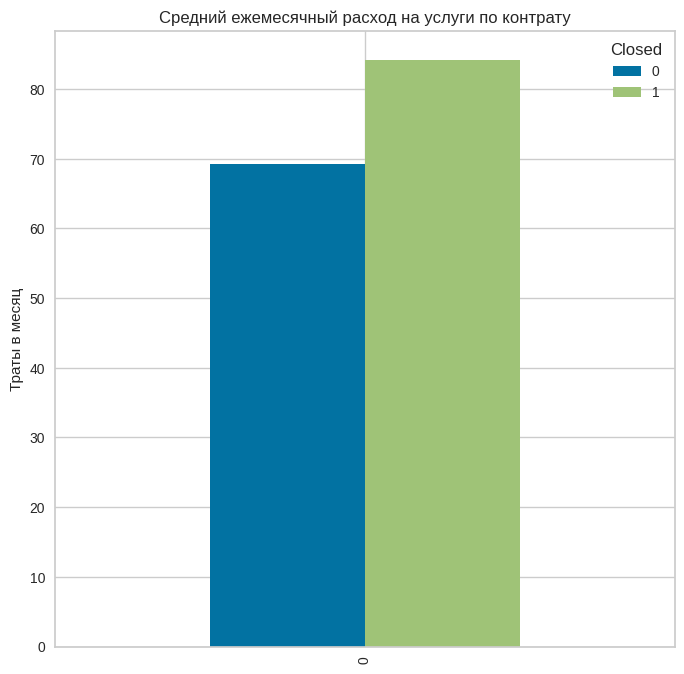

In [34]:
(data.pivot_table(index='Closed',
                  values=['MonthlyCharges'],
                  aggfunc=['median']).T
     .plot(kind='bar',
           grid=True,
           use_index=False,
           figsize=(8,8),
           ylabel='Траты в месяц',
           title='Средний ежемесячный расход на услуги по контрату'));


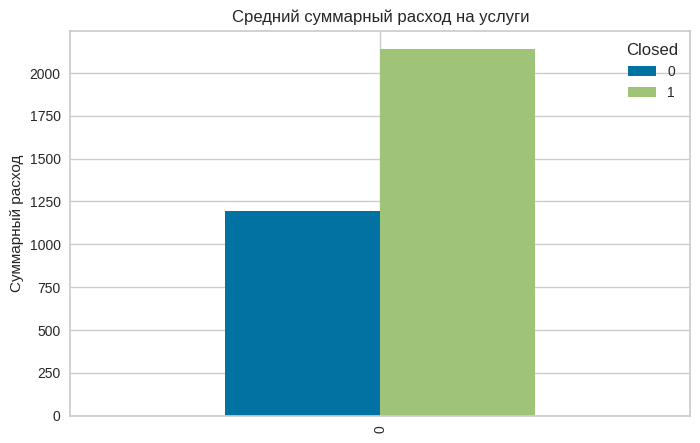

In [35]:
(data.pivot_table(index='Closed',
                  values='TotalCharges',
                  aggfunc=['median']).T
     .plot(kind='bar',
           grid=True,
           figsize=(8,5),
           use_index=False,
           ylabel='Суммарный расход',
           title='Средний суммарный расход на услуги'));


**Важно отметить то, что клиенты, которые расторгли контракты в среднем каждый месяц тратили больше денег, чем те, кто остались. Также хочется отметить то, что каждый клиент, который растог контракт в суммарно (по среднему значению) потратил больше денег, чем те, кто остался.**

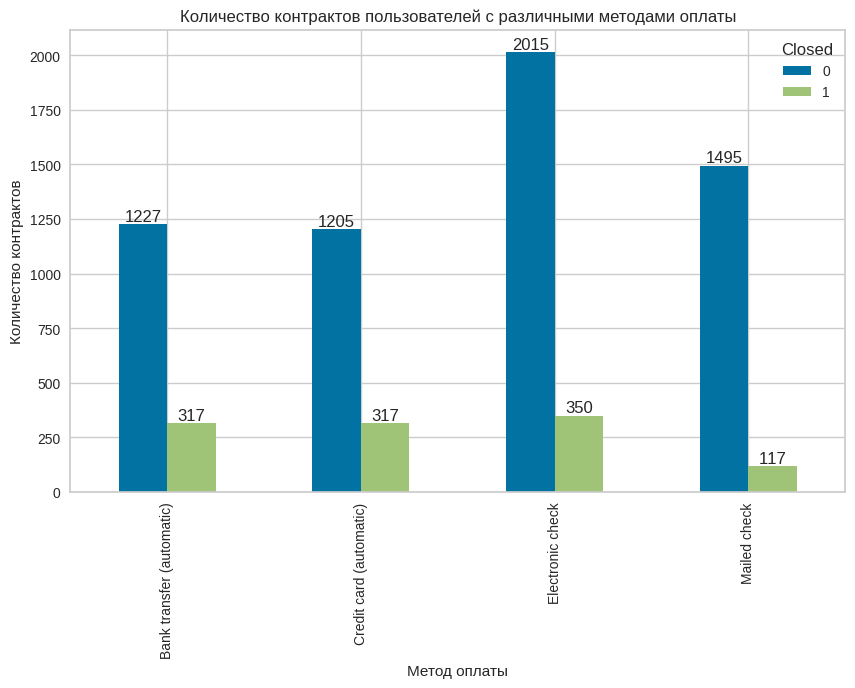

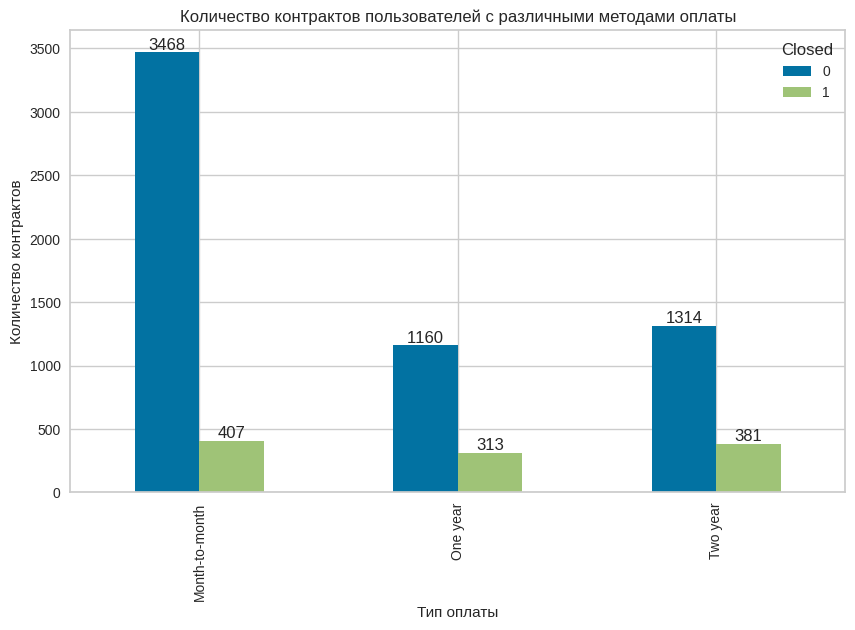

In [114]:
bar_cat_sigh(data, 
             'PaymentMethod', 
             'Количество контрактов пользователей с различными методами оплаты',
             'Метод оплаты')
bar_cat_sigh(data, 
             'Type', 
             'Количество контрактов пользователей с различными методами оплаты',
             'Тип оплаты')

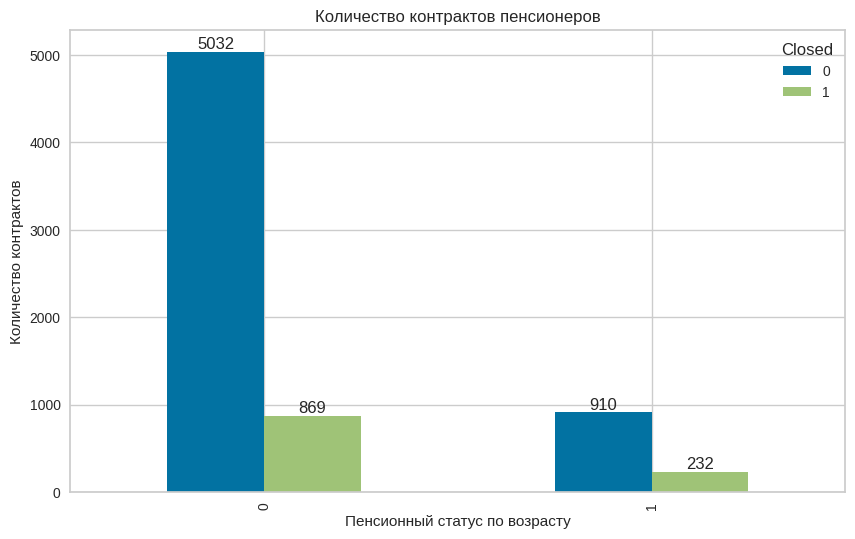

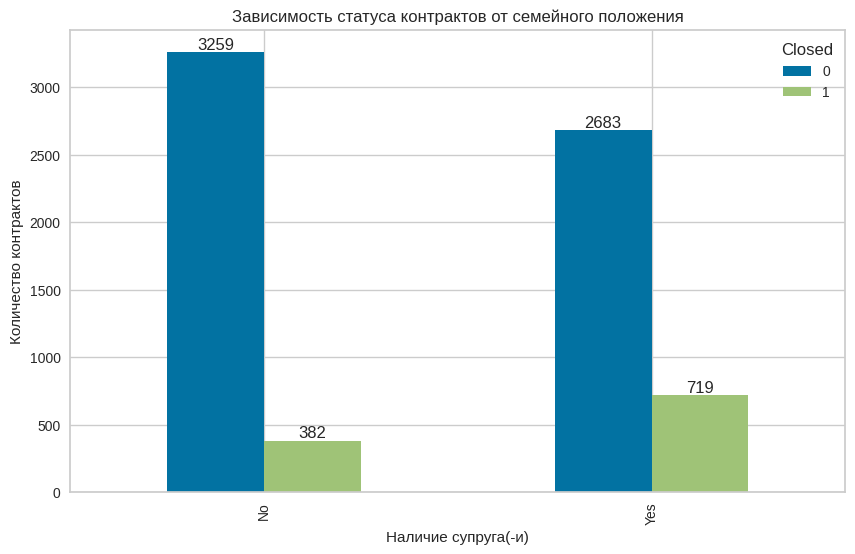

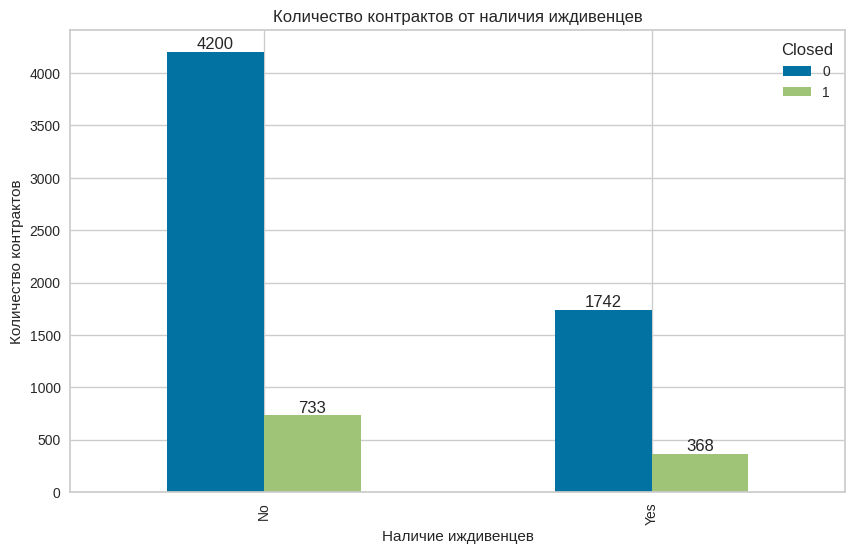

In [37]:
bar_cat_sigh(data, 
             'SeniorCitizen', 
             'Количество контрактов пенсионеров',
             'Пенсионный статус по возрасту')
bar_cat_sigh(data, 
             'Partner', 
             'Зависимость статуса контрактов от семейного положения',
             'Наличие супруга(-и)')
bar_cat_sigh(data, 
             'Dependents', 
             'Количество контрактов от наличия иждивенцев',
             'Наличие иждивенцев')

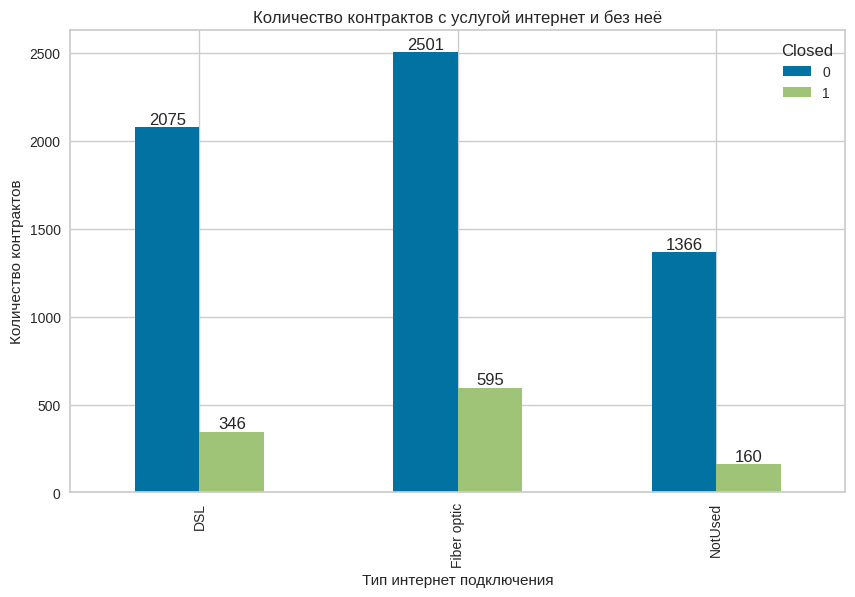

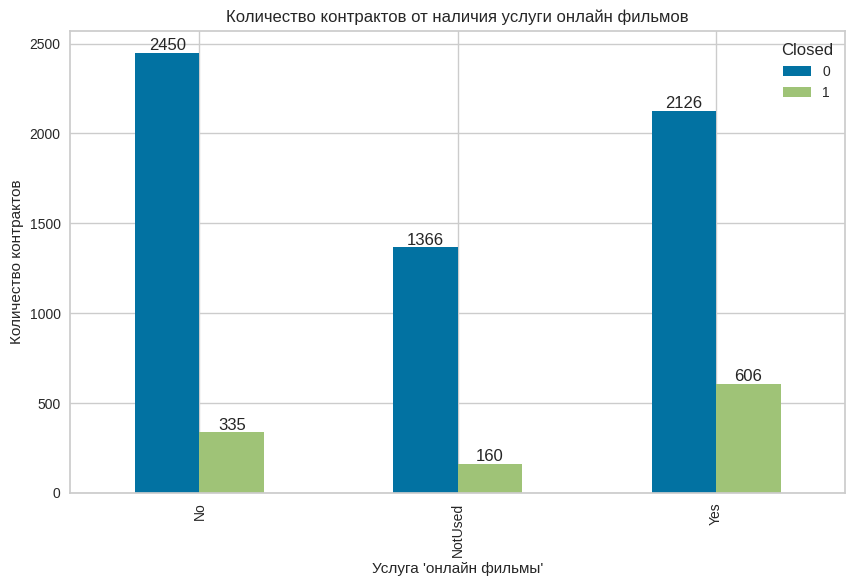

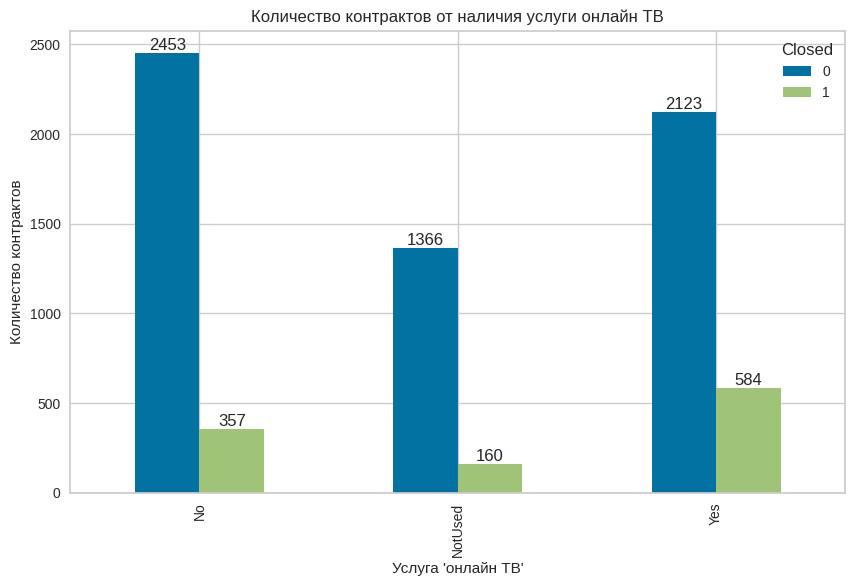

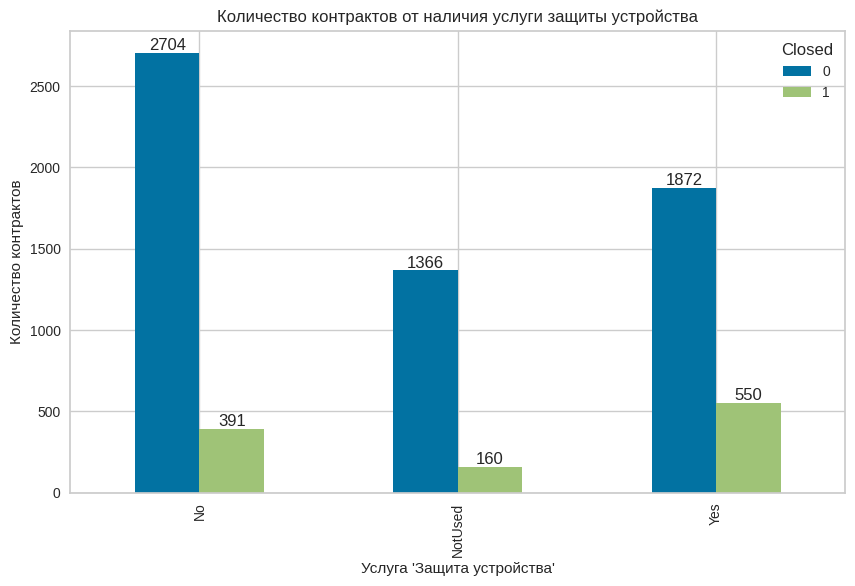

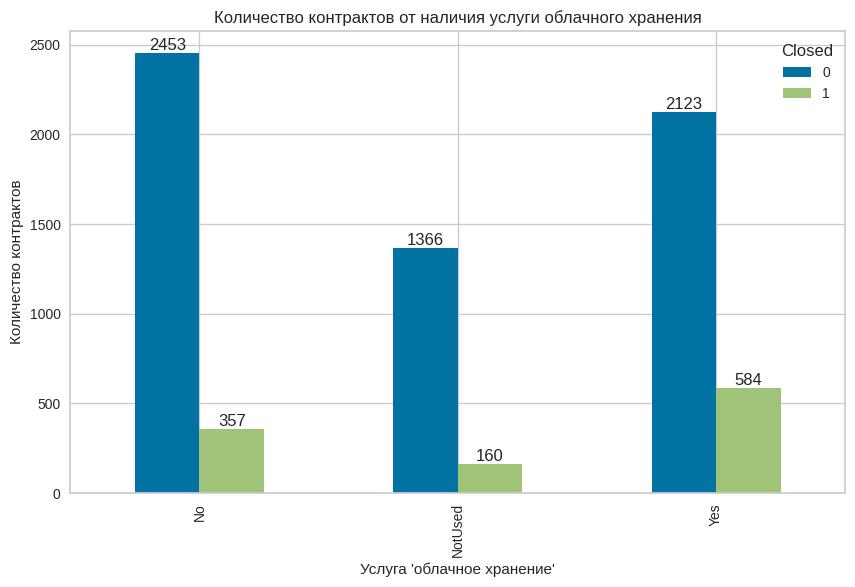

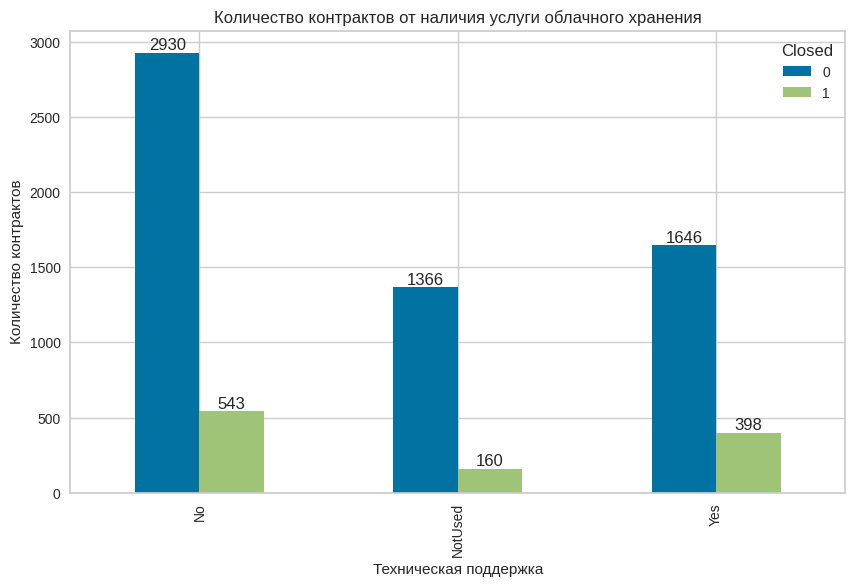

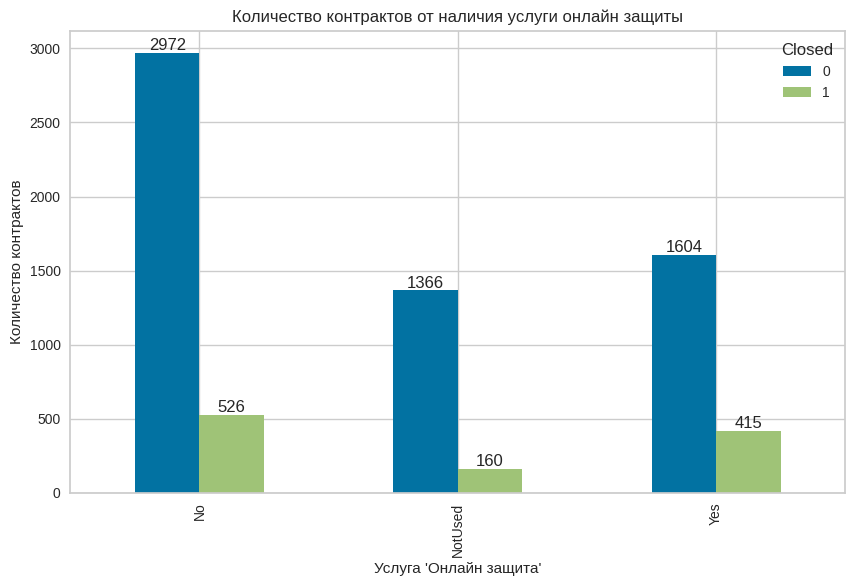

In [38]:
bar_cat_sigh(data, 
             'InternetService', 
             'Количество контрактов с услугой интернет и без неё',
             'Тип интернет подключения')
bar_cat_sigh(data, 
             'StreamingMovies', 
             'Количество контрактов от наличия услуги онлайн фильмов',
             'Услуга \'онлайн фильмы\'')
bar_cat_sigh(data, 
             'StreamingTV', 
             'Количество контрактов от наличия услуги онлайн ТВ',
             'Услуга \'онлайн ТВ\'')
                       
bar_cat_sigh(data, 
             'DeviceProtection', 
             'Количество контрактов от наличия услуги защиты устройства',
             'Услуга \'Защита устройства\'')
             
bar_cat_sigh(data, 
             'StreamingTV', 
             'Количество контрактов от наличия услуги облачного хранения',
             'Услуга \'облачное хранение\'')
bar_cat_sigh(data, 
             'TechSupport', 
             'Количество контрактов от наличия услуги облачного хранения',
             'Техническая поддержка')
bar_cat_sigh(data, 
             'OnlineSecurity', 
             'Количество контрактов от наличия услуги онлайн защиты',
             'Услуга \'Онлайн защита\'')




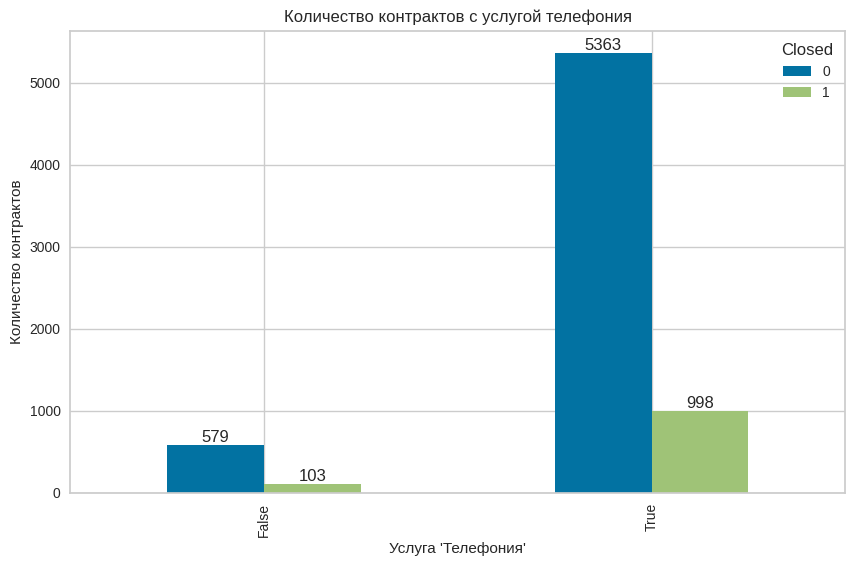

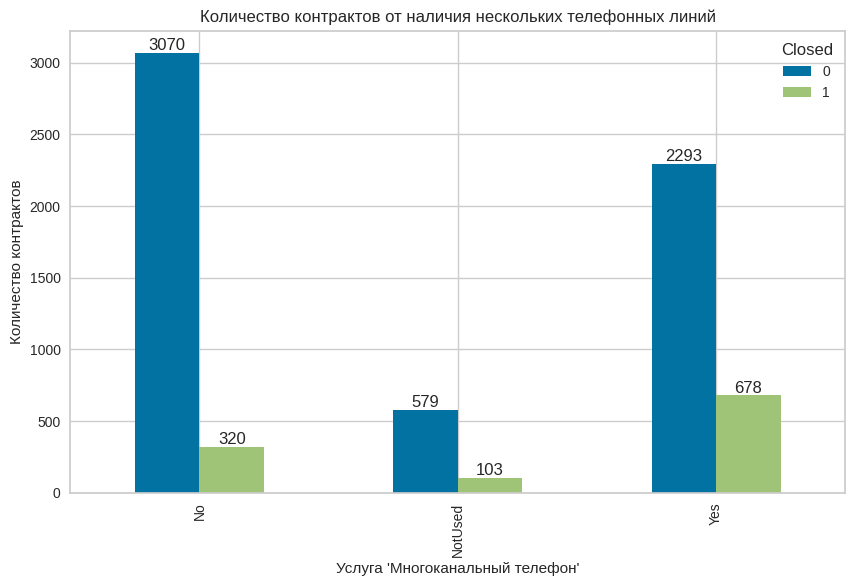

In [39]:
bar_cat_sigh(data, 
             'Phone', 
             'Количество контрактов с услугой телефония',
             'Услуга \'Телефония\'')
bar_cat_sigh(data, 
             'MultipleLines', 
             'Количество контрактов от наличия нескольких телефонных линий',
             'Услуга \'Многоканальный телефон\'')


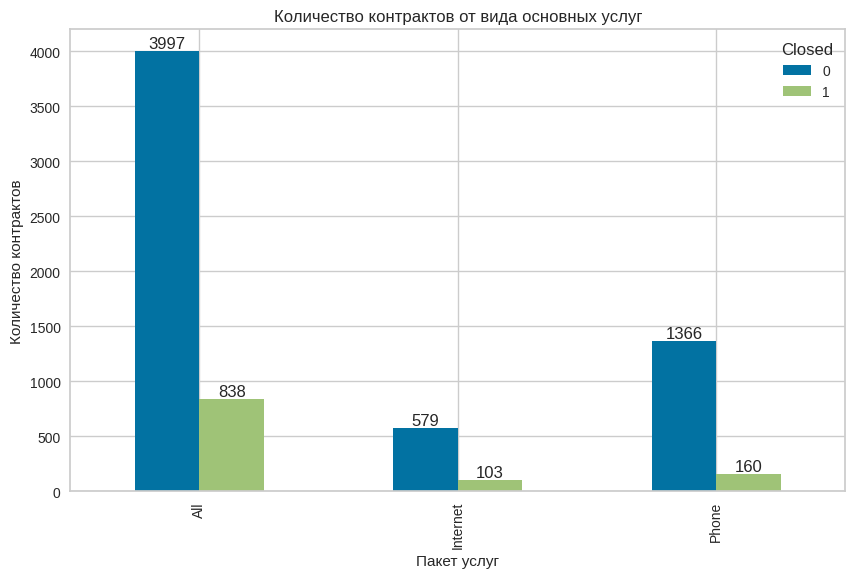

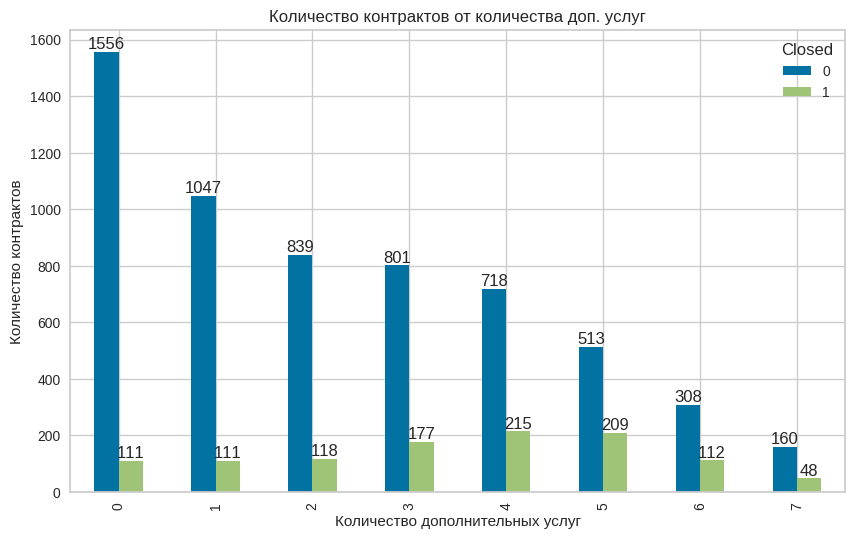

In [40]:
bar_cat_sigh(data, 
             'Services', 
             'Количество контрактов от вида основных услуг',
             'Пакет услуг')
bar_cat_sigh(data, 
             'Extras', 
             'Количество контрактов от количества доп. услуг',
             'Количество дополнительных услуг')


<b>ВЫВОД:</b>
1) Чаще всего покидают компанию клиенты, заключившине договор до 2017 года. Чем позже, тем реже становятся расторжения. Это хорошо видно на диаграмме расторжения контрактов по годам.<br>
2) Через 5 лет пользования услугами компании клиенты практически не расторгают контракты.<br>
3) Пользователи с действующими контрактами платят меньше, чем те, кто их расторгнул.<br>
4) Пользователи со счетами по электронной почте меньше расторгают контракты.<br>
5) Пользователи с супругом(-ой) чаще разрывают контракты как в количественном, так и в процентном соотношении.<br>
6) Контракты с ежемесячной оплатой разрывают реже, чем остальные.<br>
7) Пользователи, которые пользуются дополнительными услугам также чаще разрывают контракт.<br>   

## Создание и обучение моделей.

In [75]:
models_report = pd.DataFrame(columns=['Name', 'ROC-AUC Score', 'Accuracy', 'Settings'])
model_info = pd.Series(index=['Model', 'ROC-AUC Score', 'Test Accuracy', 'Test ROC-AUC Score', 'Settings'])

### Изучим баланс классов

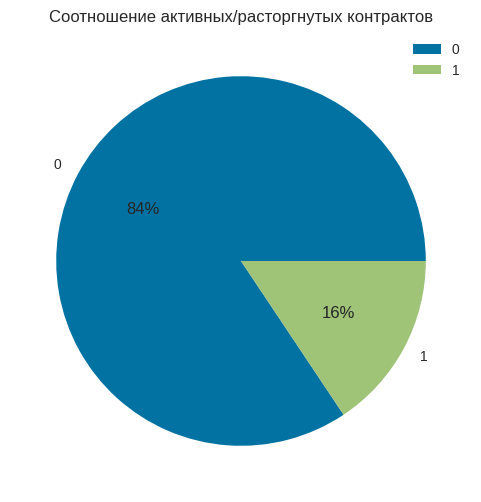

In [42]:
(data[['gender','Closed']].groupby(['Closed'])
                           .count()
                           .plot(kind='pie', 
                                 y='gender', 
                                 autopct='%1.0f%%',
                                 title='Соотношение активных/расторгнутых контрактов',
                                 figsize=(6,6),
                                 ylabel=''));

Имеется дисбаланс классов. Разница весомая, порядка 5:1.

### Исследуем мультиколлинеарность

Для линейной модели от значений в матрице коррелиции 0.8+ избавляемся.<br>
1) Избавимcя от временных признаков (EndDate, BeginDate, Year, Month).
2) Между OtherCharges и TotalCharges прямая зависимость. Оставим исходные TotalCharges.
3) Столбцы Phone, MultipleLines, Service связаны друг с другом. С целевой переменной лучшая связь у Multiplelines.<br>
4) Сильно связаны ContractDuration, Year, Month, BeginDate. Оставляем только длительность контракта.<br>
5) Столбцы с услугой интернет и доп. услугами связаны сильно между собой и со столбцом ежемесячных расходов (MonthlyCharges). Удалим их.<br>
6) Между столбцами ContractDuration и TotalCharges слишком сильная зависимость. Оставляем длительность контракта.<br>
7) Целевая переменная не зависит от признаков"пол клиента" и Discount. Отбросим.


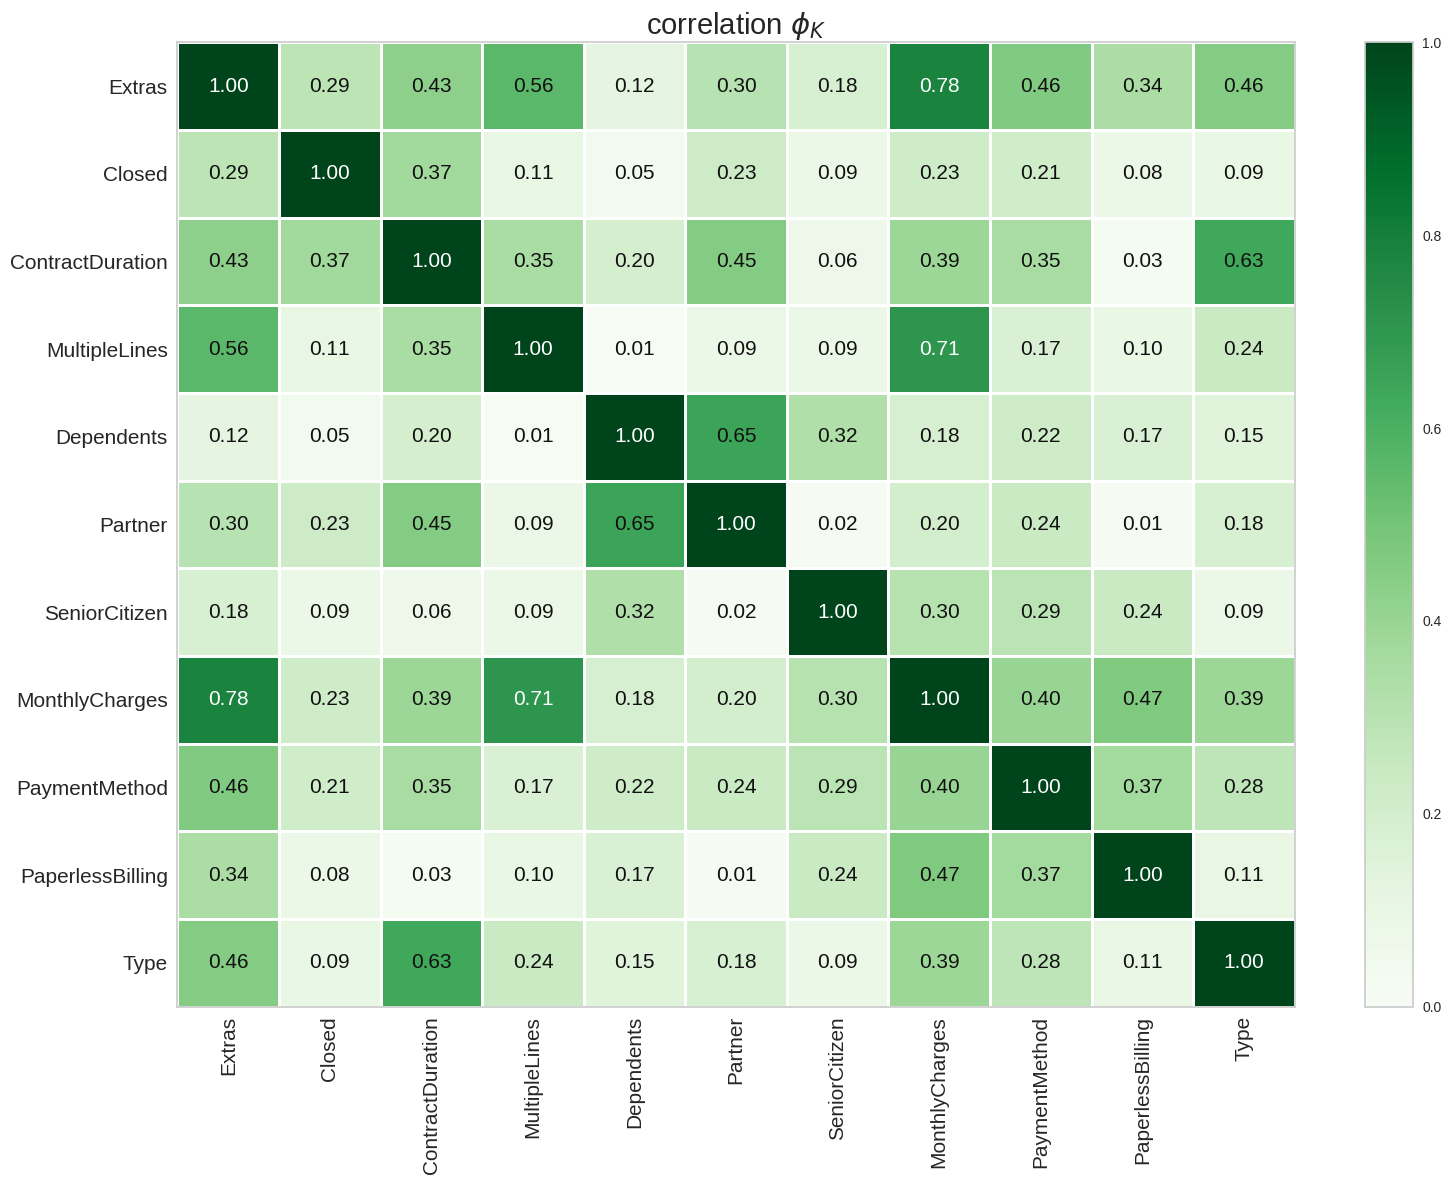

In [43]:
new_data = data.drop(['EndDate', 
                      'Month', 
                      'Year',
                      'BeginDate',
                      'Phone', 
                      'StreamingTV', 
                      'TechSupport', 
                      'OnlineSecurity', 
                      'InternetService', 
                      'StreamingMovies', 
                      'DeviceProtection',
                      'OnlineBackup',
                      'Services',
                      'OtherCharges', 
                      'TotalCharges',
                      'gender',
                      'Discount'], axis=1)

warnings.filterwarnings('ignore')
new_data_corr = \
    (new_data.phik_matrix(interval_cols=['MonthlyCharges',
                                         'ContractDuration',
                                         'Extras']))
warnings.filterwarnings('default')

plot_correlation_matrix(new_data_corr.values, 
                        x_labels=new_data_corr.columns, 
                        y_labels=new_data_corr.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(16, 12))

### Выделение целевых признаков и переменной. Создание выборок.

In [44]:
target = new_data['Closed']
features = new_data.drop('Closed', axis=1)

Поделим данные на тренировочные и тестовые выборки в соотношении 3:1.

In [45]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=.25, stratify=target, random_state=STATE)

In [46]:
display(features.shape)
display(features_train.shape)
display(features_test.shape)

(7043, 10)

(5282, 10)

(1761, 10)

### Разделение признаков на категориальные и численные.

In [47]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Type              7043 non-null   category
 1   PaperlessBilling  7043 non-null   category
 2   PaymentMethod     7043 non-null   category
 3   MonthlyCharges    7043 non-null   float16 
 4   SeniorCitizen     7043 non-null   category
 5   Partner           7043 non-null   category
 6   Dependents        7043 non-null   category
 7   MultipleLines     7043 non-null   category
 8   ContractDuration  7043 non-null   int64   
 9   Extras            7043 non-null   int64   
dtypes: category(7), float16(1), int64(2)
memory usage: 486.0+ KB


In [48]:
num_features = \
    features.select_dtypes(include=['int64', 
                                    'float16']).columns.to_list()
cat_features = \
    features.select_dtypes(include=['category']).columns.to_list()

display(num_features)
display(cat_features)


['MonthlyCharges', 'ContractDuration', 'Extras']

['Type',
 'PaperlessBilling',
 'PaymentMethod',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'MultipleLines']

### Обучение модели логистической регрессии

In [49]:
warnings.filterwarnings('ignore')
preprocessor = make_column_transformer((StandardScaler(), num_features), 
                                       (OneHotEncoder(drop='first',
                                                      handle_unknown='ignore'), cat_features))

In [50]:
pipeline = Pipeline([('pre', preprocessor),
                     ('SMOTE', SMOTE(random_state=STATE)),
                     ('lr', LogisticRegression(random_state=STATE))])

In [51]:
param_grid = {'lr__C': [1, 2, 5, 7, 10],
              'lr__max_iter': [10, 20, 40, 50],
              'lr__class_weight': ['balanced']}

In [52]:
grid = GridSearchCV(pipeline, 
                    param_grid, 
                    scoring=['roc_auc', 'accuracy'],
                    refit='roc_auc', 
                    cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=STATE), 
                    n_jobs=-1,
                    return_train_score=True)

best_lr = grid.fit(features_train, target_train)
models_report.loc[len(models_report.index)] = ['Logistic Regression', 
                                               best_lr.best_score_, 
                                               best_lr.cv_results_['mean_test_accuracy'][best_lr.best_index_], 
                                               best_lr.best_params_]
print('AUC-ROC:', best_lr.cv_results_['mean_test_roc_auc'][best_lr.best_index_])
print('Accuracy:', best_lr.cv_results_['mean_test_accuracy'][best_lr.best_index_])
print('Settings:', best_lr.best_params_)

AUC-ROC: 0.7463410876760525
Accuracy: 0.6912140423921271
Settings: {'lr__C': 1, 'lr__class_weight': 'balanced', 'lr__max_iter': 40}


### Обучение модели случайного леса

In [53]:
warnings.filterwarnings('ignore')
preprocessor = make_column_transformer((StandardScaler(), num_features), 
                                       (OrdinalEncoder(handle_unknown='use_encoded_value',
                                                       unknown_value=-1), cat_features))

In [54]:
pipeline = Pipeline([('pre', preprocessor),
                     ('SMOTE', SMOTE(random_state=STATE)), 
                     ('forest', RandomForestClassifier())])

param_grid = {'forest__max_depth': [None] + [i for i in range(2, 7)],
              'forest__n_estimators': range(20, 900, 50),
              'forest__class_weight': ['balanced'],
              'forest__random_state': [STATE]}

In [55]:
grid = GridSearchCV(pipeline, 
                    param_grid, 
                    scoring=['roc_auc', 'accuracy'],
                    refit='roc_auc',
                    verbose=5,
                    cv = StratifiedKFold(n_splits=5, 
                                         shuffle=True,
                                         random_state=STATE), 
                    n_jobs=-1)

best_rf = grid.fit(features_train, target_train)
models_report.loc[len(models_report.index)] = ['Random Forest Classifier', 
                                               best_rf.best_score_, 
                                               best_rf.cv_results_['mean_test_accuracy'][best_rf.best_index_], 
                                               best_rf.best_params_]
warnings.filterwarnings('default')
print('AUC-ROC:', best_rf.cv_results_['mean_test_roc_auc'][best_rf.best_index_])
print('Accuracy:', best_rf.cv_results_['mean_test_accuracy'][best_rf.best_index_])
print('Settings:', best_rf.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
AUC-ROC: 0.8220949351070216
Accuracy: 0.7661862833634357
Settings: {'forest__class_weight': 'balanced', 'forest__max_depth': 6, 'forest__n_estimators': 870, 'forest__random_state': 280823}


In [56]:
print(best_rf.best_params_)

{'forest__class_weight': 'balanced', 'forest__max_depth': 6, 'forest__n_estimators': 870, 'forest__random_state': 280823}


### Модель LightGBM

In [57]:
%time
preprocessor = make_column_transformer((StandardScaler(), num_features), 
                                       (OrdinalEncoder(handle_unknown='use_encoded_value',
                                                       unknown_value=-1), cat_features))

pipeline = Pipeline ([('pre', preprocessor),
                      ('SMOTE', SMOTE(random_state=STATE)),
                      ('lgbm', LGBMClassifier(device_type='cpu'))])
    
param_grid = {'lgbm__n_estimators': [100, 200, 500],
              'lgbm__num_leaves': [10, 20, 40],
              'lgbm__max_depth': range(1, 13, 2),
              'lgbm__min_child_weight': range(1, 13, 2),
              'lgbm__learning_rate': [0.05],
              'lgbm__class_weight': ['balanced']} 

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 10 µs


In [58]:
grid = GridSearchCV(pipeline, 
                    param_grid, 
                    scoring=['roc_auc', 'accuracy'],
                    refit='roc_auc',
                    cv = StratifiedKFold(n_splits=5, 
                                         shuffle=True,
                                         random_state=STATE),
                    verbose=100,
                    n_jobs=-1)

best_lgbm = grid.fit(features_train, target_train)
models_report.loc[len(models_report.index)] = ['Light GBM', 
                                               best_lgbm.best_score_, 
                                               best_lgbm.cv_results_['mean_test_accuracy'][best_lgbm.best_index_], 
                                               best_lgbm.best_params_]
print('AUC-ROC:', best_lgbm.cv_results_['mean_test_roc_auc'][best_lgbm.best_index_])
print('Accuracy:', best_lgbm.cv_results_['mean_test_accuracy'][best_lgbm.best_index_])
print('Settings:', best_lgbm.best_params_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[LightGBM] [Info] Number of positive: 4456, number of negative: 4456
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2333
[LightGBM] [Info] Number of data points in the train set: 8912, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
AUC-ROC: 0.9094997482149351
Accuracy: 0.9110158467360453
Settings: {'lgbm__class_weight': 'balanced', 'lgbm__learning_rate': 0.05, 'lgbm__max_depth': 11, 'lgbm__min_child_weight': 1, 'lgbm__n_estimators': 500, 'lgbm__num_leaves': 20}


### Модель CatBoost

In [59]:
%time
preprocessor = make_column_transformer((StandardScaler(), num_features), 
                                       (OrdinalEncoder(handle_unknown='use_encoded_value',
                                                       unknown_value=-1), cat_features))

pipeline = Pipeline ([('pre', preprocessor),
                      ('SMOTE', SMOTE()),
                      ('catb', CatBoostClassifier())])
    
param_grid = {'catb__iterations': [750, 1000],
              'catb__depth': [3, 5, 7],
              'catb__learning_rate': [0.01, 0.05, 0.001]} 

grid_catb = GridSearchCV(pipeline, 
                         param_grid, 
                         scoring=['roc_auc', 'accuracy'],
                         refit='roc_auc',
                         cv = StratifiedKFold(n_splits=5, 
                                         shuffle=True,
                                         random_state=STATE),
                         verbose=100,
                         n_jobs=-1)

best_catb = grid_catb.fit(features_train, target_train)
models_report.loc[len(models_report.index)] = ['CatBoost Classifier', 
                                               best_catb.best_score_, 
                                               best_catb.cv_results_['mean_test_accuracy'][best_catb.best_index_], 
                                               best_catb.best_params_]
print('AUC-ROC:', best_catb.cv_results_['mean_test_roc_auc'][best_catb.best_index_])
print('Accuracy:', best_catb.cv_results_['mean_test_accuracy'][best_catb.best_index_])
print('Settings:', best_catb.best_params_)

CPU times: user 81 µs, sys: 11 µs, total: 92 µs
Wall time: 16.5 µs
Fitting 5 folds for each of 18 candidates, totalling 90 fits
0:	learn: 0.6739266	total: 69.2ms	remaining: 1m 9s
1:	learn: 0.6558395	total: 73.8ms	remaining: 36.8s
2:	learn: 0.6389882	total: 78.2ms	remaining: 26s
3:	learn: 0.6251766	total: 82.9ms	remaining: 20.6s
4:	learn: 0.6131318	total: 87.3ms	remaining: 17.4s
5:	learn: 0.6019451	total: 92.1ms	remaining: 15.3s
6:	learn: 0.5889863	total: 96.7ms	remaining: 13.7s
7:	learn: 0.5785056	total: 102ms	remaining: 12.6s
8:	learn: 0.5683615	total: 106ms	remaining: 11.7s
9:	learn: 0.5592774	total: 110ms	remaining: 10.9s
10:	learn: 0.5488963	total: 114ms	remaining: 10.3s
11:	learn: 0.5425161	total: 118ms	remaining: 9.75s
12:	learn: 0.5354026	total: 123ms	remaining: 9.31s
13:	learn: 0.5275252	total: 127ms	remaining: 8.93s
14:	learn: 0.5222529	total: 131ms	remaining: 8.6s
15:	learn: 0.5170449	total: 135ms	remaining: 8.3s
16:	learn: 0.5100456	total: 140ms	remaining: 8.07s
17:	learn: 0

ВЫВОД:<br> Лучший результат показала модель градиентного бустинга CarBoost c результатом AUC-ROC = 0.92.

In [81]:
models_report.sort_values(by='ROC-AUC Score', ascending=False).set_index('Name')

,ROC-AUC Score,Accuracy,Settings
Name,,,
CatBoost Classifier,0.916461,0.917833,"{'catb__depth': 5, 'catb__iterations': 1000, '..."
Light GBM,0.909500,0.911016,"{'lgbm__class_weight': 'balanced', 'lgbm__lear..."
Random Forest Classifier,0.822095,0.766186,"{'forest__class_weight': 'balanced', 'forest__..."
Logistic Regression,0.746341,0.691214,"{'lr__C': 1, 'lr__class_weight': 'balanced', '..."


## Тестирование выбранной модели

In [ ]:
model_info['Model'] = 'CatBoost Classifier'
model_info['ROC-AUC Score'] = best_catb.best_score_
model_info['Settings'] = best_catb.best_params_

In [62]:
best_model = best_catb
predictions = best_model.predict(features_test)

### Построим ROC-кривую и посчитаем показатель Accuracy и AUC-ROC для тестовой выборки.

In [87]:
model_info['Test Accuracy'] = round(accuracy_score(target_test, predictions),2)
probabilities_test = best_model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
model_info['Test ROC-AUC Score'] = round(roc_auc_score(target_test, probabilities_one_test), 2)
model_info

Model                                               CatBoost Classifier
ROC-AUC Score                                                  0.916461
Test Accuracy                                                      0.92
Test ROC-AUC Score                                                 0.93
Settings              {'catb__depth': 5, 'catb__iterations': 1000, '...
dtype: object

Метрика Accuracy отражает точность предсказания классов. В данном случае Accuracy со значением 0.93 говорит о том, что в 93% модель правильно разелила клиентов на тех кто останется и тех, кто уйдёт и в 7% эти предсказания оказались неверными. <br>
Метрика Accuracy отностится не только к предсказанию ухода клиентов, но и к предсказанию того, что клиент останется. При этом может так получиться, что значение метрики высокое, а качество предсказаний ухода клиента могут быть неточными.
Для выбора модели предсказания была выбрана более совершенная метрика AUC-ROC, которая учитывает этот критерий.

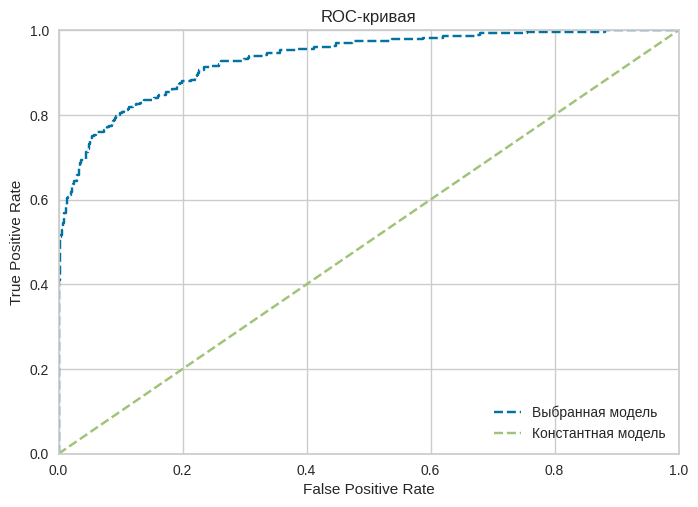

In [64]:
dummy_model = DummyClassifier(strategy='constant', constant=1)
dummy_model.fit(features_train, target_train)
probabilities_test_dummy = dummy_model.predict_proba(features_test)
probabilities_one_test_dummy = probabilities_test_dummy[:, 1]

fpr, tpr, thresholds = roc_curve (target_test, probabilities_one_test)
fpr_const, tpr_const, thresholds_const = roc_curve (target_test, probabilities_one_test_dummy)

plt.figure()
plt.plot(fpr, tpr, linestyle='--', label='Выбранная модель')
plt.plot(fpr_const, tpr_const, linestyle='--', label='Константная модель')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend()
plt.show()

Из графика видно, что выбранная модель строит прогнозы адекватно, на фоне константной модели. Для наглядности построим матрицу ошибок.

### Матрица ошибок

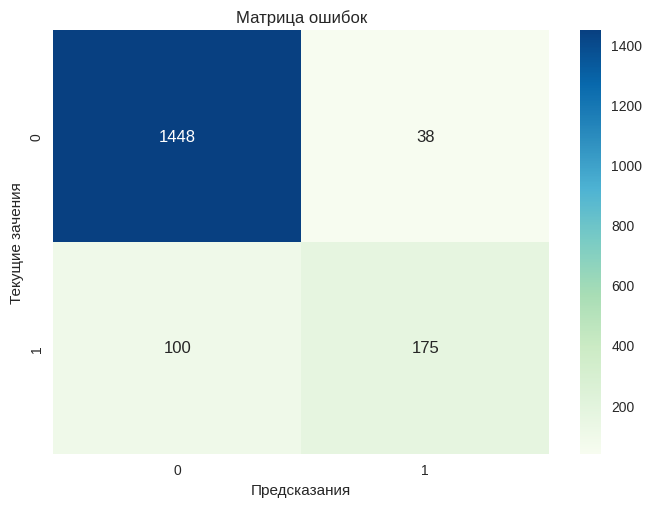

In [65]:
cm = confusion_matrix(target_test, predictions)
sns.heatmap(cm, 
            annot=True, 
            fmt='.0f',
            cmap='GnBu')
plt.title('Матрица ошибок')
plt.xlabel('Предсказания')
plt.ylabel('Текущие зачения');

На тестовой выборке моделью были "подсвечены" 215 клиентов. Из них 36 те, которые не уйдут, а 179 которые уйдут. Эти цифры могут быть важны при принятии каких-либо решений, для удержания клиентов.<br>
Из 275 клиентов, которые уйдёт модели удалось выявить 179, которые уйдут.<br> 
Обратная сторона: <br>1486 реальных клиентов, которые не планируют уйти модель вывила 1450.<br>
Из 1546 клиентов, которых модель посчитала лояльными в реальности оказалиь 1450.<br>
Данные цифры и соотношения могут быть полезны при предложении специальных условий для удержания нелояльных клиентов и какие дополнительные издержки может понести компания.

### Оценка важности признаков модели

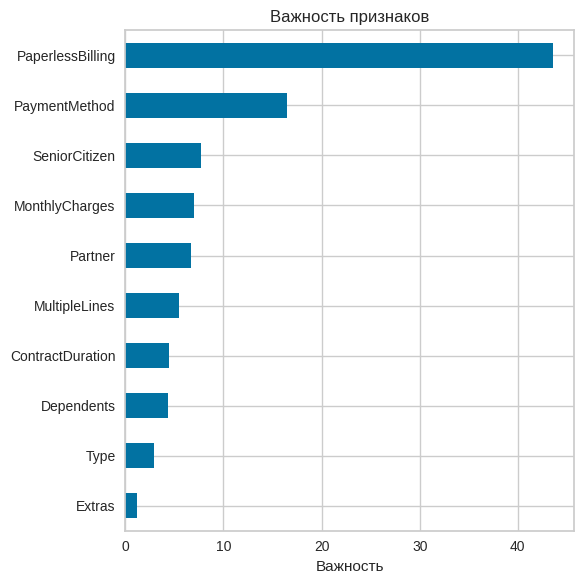

In [66]:
feat_imp = pd.Series(best_model.best_estimator_._final_estimator.feature_importances_,
                         features_test.columns).sort_values()

fig, ax = plt.subplots(figsize=(6,6))
feat_imp.plot.barh()
ax.set_title("Важность признаков")
ax.set_xlabel('Важность')
fig.tight_layout()

Из графика можно заметить, что самыми важными признаками, по которым модель предсказывать уход клиентов это использование безналичных платежей, метод оплаты, ежемесячные расходы, пенсионный возраст и наличие супруга(-и).

Для более точной оценки важности применим дополнительно более совершенный метод оценки при помощи билиотеки SHAP, которая учитывает важность признака на принадлежность классу в зависимости от значения признака.

unclosed file <_io.TextIOWrapper name='/tmp/tmpp43u5uu1' mode='r' encoding='UTF-8'>
unclosed file <_io.TextIOWrapper name='/tmp/tmp151vja6c' mode='r' encoding='UTF-8'>
100%|===================| 5261/5282 [02:43<00:00]        No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


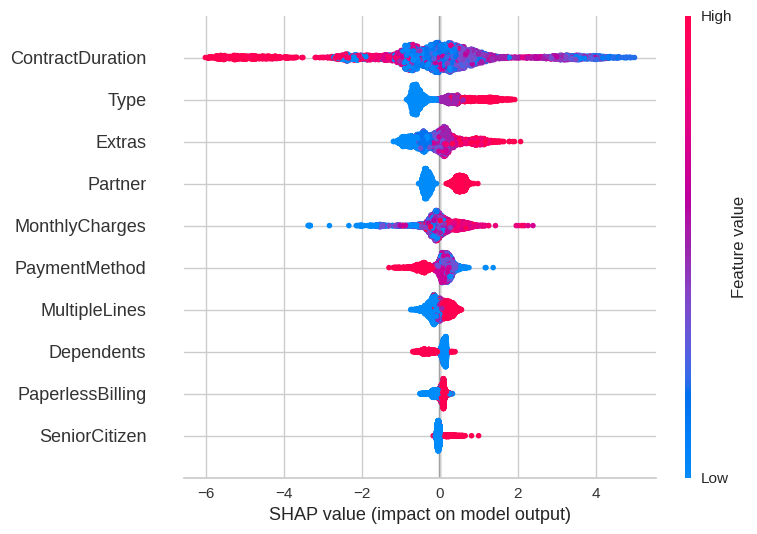

In [115]:
preprocessor.fit(features_train)
features_pre = pd.DataFrame(preprocessor.transform(features_train), 
                            columns=(num_features+cat_features))
explainer = shap.Explainer(best_model.best_estimator_._final_estimator, features_pre)
shap_values = explainer.shap_values(features_pre)
shap.summary_plot(shap_values, features_pre)

Из графика можно заметить, что ТОП5 важных признаков:
- Длительность контракта
- Тип оплаты
- Количество доп. услуг
- Наличие супруга(-и)
- Ежемесячные расходы

## Отчёт

### План работы

- Изучение технического задания проекта.

- Загрузка, группировка, предобработка данных.

- Добавление целевой переменной. Добавление новых признаков. Выявление зависимостей.

- Подготовка данных к созданию и обучению моделей.

- Выбор моделей машинного обучения. Тестирование.

- Оценка важности признаков.

- Итоговый вывод.

Все шаги успешно выполнены в соответствит с планом.

Все столбцы исходных данных разделены на категориальные (и приведены к соответствующему типу) и численные. Отсутствие информации о клиентах в таблицах интернет услуг и телефонии были воспринято как не использовани соответствующей услугой и заполнено значением NotUsed.

При подготовке данных к обучению необходимо было отбросить некоторые исходные признаки из-за сильных связей между собой, а также некоторые созданные в процессе анализа. Также было принято решение не использовать признаки, которые не связаны с целевой переменной согласно таблице корреляции (пол клиента). Целевая переменная Closed была создана на основе даты окончания контракта (1 - контракт расторгнут, 0 - действующий контракт).

### Результаты анализа исходных данных

Для целевой переменной были построены графики зависимостей от имеющихся данных о клиенте, что позволило сделать некоторые закономерности:<br>
1) Чаще всего покидают компанию клиенты, заключившине договор до 2017 года. Чем позже, тем реже становятся расторжения. Это хорошо видно на диаграмме расторжения контрактов по годам.<br>
2) Через 5 лет пользования услугами компании клиенты практически не расторгают контракты.<br>
3) Пользователи с действующими контрактами платят меньше, чем те, кто их расторгнул.<br>
4) Пользователи со счетами по электронной почте меньше расторгают контракты.<br>
5) Пользователи с супругом(-ой) чаще разрывают контракты как в количественном, так и в процентном соотношении.<br>
6) Контракты с ежемесячной оплатой разрывают реже, чем остальные.<br>
7) Пользователи, которые пользуются дополнительными услугам также чаще разрывают контракт.<br> 


### Целевые признаки

Для обучения моделей были отобраные признаки были разделены на категориальные и численные.<br> К категориальным были применены кодировщики One-Hot Encoder и Ordinal Encoder, а для численных была применена функция масштабирования StandardScaler. Дополнительно был создан количественный признак, содержащий количество доп. услуг.<br>
<u>Категориальные признаки:</u><br>
<ul><li>PaperlessBilling (использование безналичного расчета);</li>
<li>PaymentMethod (способ оплаты);</li>
<li>Dependents (наличие иждивенцев);</li>
<li>SeniorCitizen (наличие пенсионного статуса по возрасту);</li>
<li>Partner (наличие супруга(и));</li>
<li>MultipleLines (услуга многоканальной телефонии).</li></ul>
<u>Численные признаки:</u><br>
<ul><li>MonthlyCharges (ежемесячные траты по договору);</li>
<li>TotalCharges (общая выручка с клиента);</li>
<li>Extras (количество дополнительных услуг).</li></ul>

### Метрики обученных модели на кросс-валидации

In [82]:
models_report.sort_values(by='ROC-AUC Score', ascending=False).set_index('Name')

,ROC-AUC Score,Accuracy,Settings
Name,,,
CatBoost Classifier,0.916461,0.917833,"{'catb__depth': 5, 'catb__iterations': 1000, '..."
Light GBM,0.909500,0.911016,"{'lgbm__class_weight': 'balanced', 'lgbm__lear..."
Random Forest Classifier,0.822095,0.766186,"{'forest__class_weight': 'balanced', 'forest__..."
Logistic Regression,0.746341,0.691214,"{'lr__C': 1, 'lr__class_weight': 'balanced', '..."


### Результат лучшей модели на кросс-валидации и на тестовой выборке

In [97]:
pd.DataFrame(model_info).T.set_index('Model')

,ROC-AUC Score,Test Accuracy,Test ROC-AUC Score,Settings
Model,,,,
CatBoost Classifier,0.916461,0.92,0.93,"{'catb__depth': 5, 'catb__iterations': 1000, '..."


### Матрица ошибок

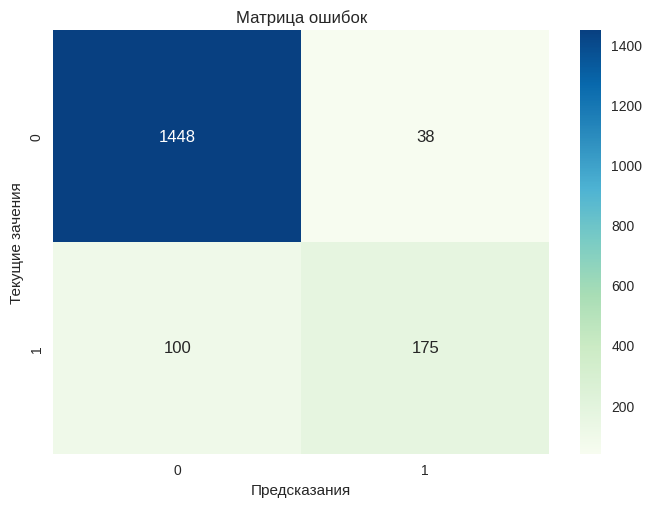

In [69]:
cm = confusion_matrix(target_test, predictions)
sns.heatmap(cm, 
            annot=True, 
            fmt='.0f',
            cmap='GnBu')
plt.title('Матрица ошибок')
plt.xlabel('Предсказания')
plt.ylabel('Текущие зачения');

- На тестовой выборке моделью были "подсвечены" 215 клиентов. Из них 36 те, которые не уйдут, а 179 которые уйдут. Эти цифры могут быть важны при принятии каких-либо решений, для удержания клиентов.<br>
- Из 275 клиентов, которые уйдёт модели удалось выявить 179, которые уйдут.<br> 
- Из 1486 реальных клиентов, которые не планируют уйти модель вывила 1450.<br>
- Из 1546 клиентов, которых модель посчитала лояльными в реальности оказалиь 1450.<br>
Данные цифры и соотношения могут быть полезны при предложении специальных условий для удержания нелояльных клиентов и какие дополнительные издержки может понести компания при принятии соответствующих решений.

### Оценка важности признаков модели

Для оценки важности применим инструменты библиотеки SHAP.

unclosed file <_io.TextIOWrapper name='/tmp/tmpk0jmelpe' mode='r' encoding='UTF-8'>
unclosed file <_io.TextIOWrapper name='/tmp/tmpmdtoozj1' mode='r' encoding='UTF-8'>
 99%|===================| 5251/5282 [02:37<00:00]        No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


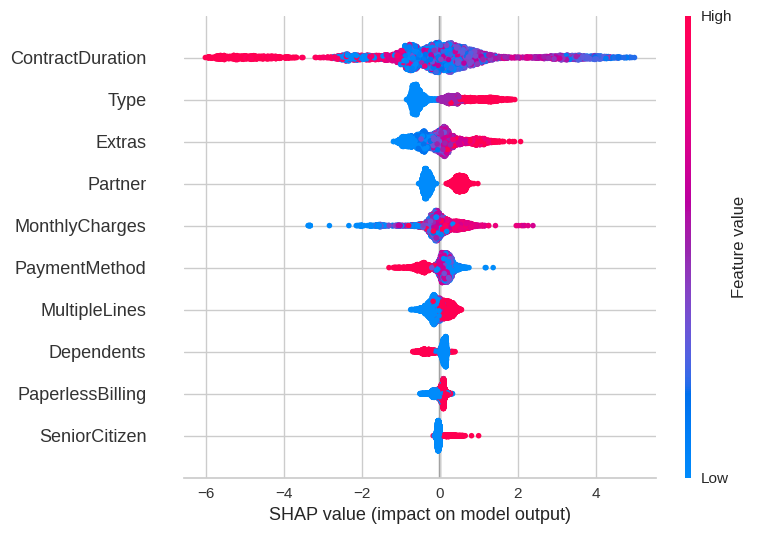

In [112]:
preprocessor.fit(features_train)
features_pre = pd.DataFrame(preprocessor.transform(features_train), 
                            columns=(num_features+cat_features))
explainer = shap.Explainer(best_model.best_estimator_._final_estimator, features_pre)
shap_values = explainer.shap_values(features_pre)
shap.summary_plot(shap_values, features_pre)

Из графика можно заметить, что ТОП5 важных признаков:
- Длительность контракта
- Тип оплаты
- Количество доп. услуг
- Наличие супруга(-и)
- Ежемесячные расходы